# Wildfire Detection

### Importing Libraries

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

import seaborn as sns
from tensorflow.keras.utils import plot_model
# from tensorflow_model_optimization.sparsity import keras as sparsity

### Environment Setup

In [2]:
train_dir = os.path.join("compress", "train")
val_dir = os.path.join("compress", "val")
test_dir = os.path.join("compress", "test")

In [3]:
print(tf.config.get_visible_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### Initialize data generators with augmentation

In [ ]:
# ImageDataGenerator for original images (no augmentation)
original_datagen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for augmented images
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [5]:
batch_size = 32
img_height, img_width = 224, 224  # ResNet50V2/EfficientNet expects 224x224 images

In [ ]:
# Original images generator
original_train_generator = original_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Augmented images generator
augmented_train_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Validation images generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)

# Augmented validation images generator
val_augmented_generator = val_augmented_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True
)


Found 1887 images belonging to 2 classes.
Found 1887 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Found 402 images belonging to 2 classes.

Original Dataset Class Counts:
fire: 730
nofire: 1157

Augmented Dataset Class Counts:
fire: 730
nofire: 1157

Validation Dataset Class Counts:
fire: 156
nofire: 246

Augmented Validation Dataset Class Counts:
fire: 156
nofire: 246

Training dataset size: 3774 samples
Validation dataset size: 804 samples


In [ ]:

# Get class indices
class_indices = original_train_generator.class_indices
class_names = list(class_indices.keys())

# Get number of samples in each class for the original and augmented datasets
original_class_counts = {class_name: 0 for class_name in class_names}
augmented_class_counts = {class_name: 0 for class_name in class_names}

for class_name, class_index in class_indices.items():
    original_class_counts[class_name] = sum(original_train_generator.classes == class_index)
    augmented_class_counts[class_name] = sum(augmented_train_generator.classes == class_index)

val_class_counts = {class_name: 0 for class_name in class_names}
augmented_val_class_counts = {class_name: 0 for class_name in class_names}

for class_name, class_index in class_indices.items():
    val_class_counts[class_name] = sum(val_generator.classes == class_index)
    augmented_val_class_counts[class_name] = sum(val_augmented_generator.classes == class_index)

# Print the results
print("\nOriginal Dataset Class Counts:")
for class_name, count in original_class_counts.items():
    print(f"{class_name}: {count}")

print("\nAugmented Dataset Class Counts:")
for class_name, count in augmented_class_counts.items():
    print(f"{class_name}: {count}")


print("\nValidation Dataset Class Counts:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count}")

print("\nAugmented Validation Dataset Class Counts:")
for class_name, count in augmented_val_class_counts.items():
    print(f"{class_name}: {count}")



In [ ]:

# Function to create a tf.data.Dataset from ImageDataGenerator
def create_dataset(generator):
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None, img_height, img_width, 3], [None])
    )
    dataset = dataset.unbatch().batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

original_dataset = create_dataset(original_train_generator)
augmented_dataset = create_dataset(augmented_train_generator)

original_val_dataset = create_dataset(val_generator)
augmented_val_dataset = create_dataset(val_augmented_generator)

combined_train_dataset = original_dataset.concatenate(augmented_dataset)
combined_val_dataset = original_val_dataset.concatenate(augmented_val_dataset)


In [ ]:

# Calculate the number of samples in the training dataset
train_samples = original_train_generator.samples + augmented_train_generator.samples
val_samples = val_generator.samples + val_augmented_generator.samples
# Calculate the number of batches for validation and training

# Print the sizes of the datasets
print(f"\nTraining dataset size: {train_samples} samples")
print(f"Validation dataset size: {val_samples} samples")


In [7]:
# Print the number of samples in each dataset for each class
print("Number of samples in each dataset for each class:")

print("\nOriginal Dataset Class Counts:")
for class_name, count in original_class_counts.items():
    print(f"{class_name}: {count}")

print("\nAugmented Dataset Class Counts:")
for class_name, count in augmented_class_counts.items():
    print(f"{class_name}: {count}")

# Calculate and print the combined dataset class counts
combined_class_counts = {class_name: original_class_counts[class_name] + augmented_class_counts[class_name] for class_name in class_names}

print("\nCombined Dataset Class Counts:")
for class_name, count in combined_class_counts.items():
    print(f"{class_name}: {count}")

# Print the number of samples in each validation dataset for each class
print("\nValidation Dataset Class Counts:")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count}")

print("\nAugmented Validation Dataset Class Counts:")
for class_name, count in augmented_val_class_counts.items():
    print(f"{class_name}: {count}")

# Calculate and print the combined validation dataset class counts
combined_val_class_counts = {class_name: val_class_counts[class_name] + augmented_val_class_counts[class_name] for class_name in class_names}

print("\nCombined Validation Dataset Class Counts:")
for class_name, count in combined_val_class_counts.items():
    print(f"{class_name}: {count}")

Number of samples in each dataset for each class:

Original Dataset Class Counts:
fire: 730
nofire: 1157

Augmented Dataset Class Counts:
fire: 730
nofire: 1157

Combined Dataset Class Counts:
fire: 1460
nofire: 2314

Validation Dataset Class Counts:
fire: 156
nofire: 246

Augmented Validation Dataset Class Counts:
fire: 156
nofire: 246

Combined Validation Dataset Class Counts:
fire: 312
nofire: 492


In [8]:
# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_dataset = create_dataset(test_generator)

Found 410 images belonging to 2 classes.


In [9]:
# Get class indices
test_class_indices = test_generator.class_indices
test_class_names = list(test_class_indices.keys())

# Get number of samples in each class for the test dataset
test_class_counts = {class_name: 0 for class_name in test_class_names}

for class_name, class_index in test_class_indices.items():
    test_class_counts[class_name] = sum(test_generator.classes == class_index)

# Print the results
print("Test Dataset Class Counts:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Test Dataset Class Counts:
fire: 159
nofire: 251


### Data Visualization

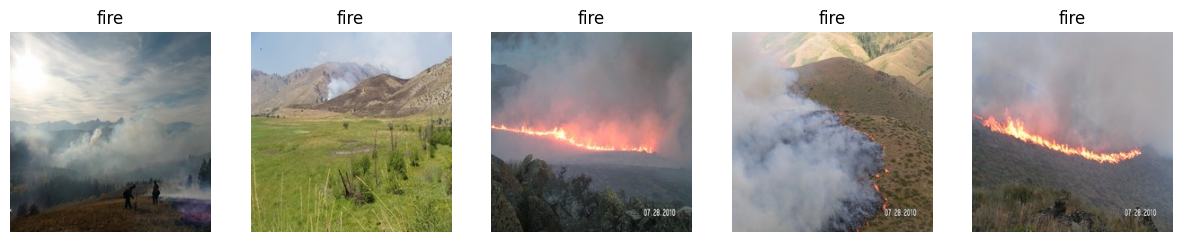

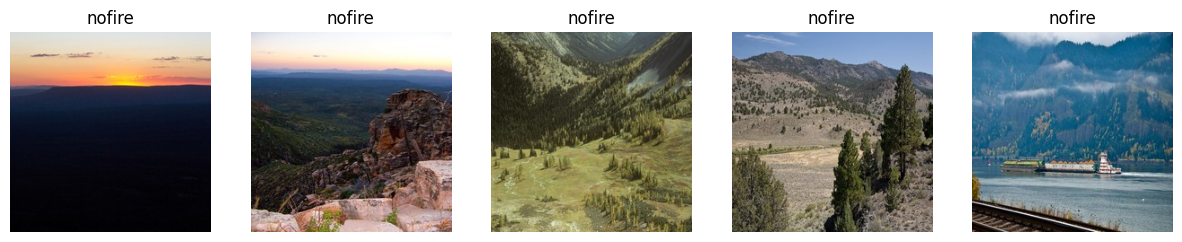

In [10]:
def plot_images(directory, category, num_images):
    category_dir = os.path.join(directory, category)
    images = os.listdir(category_dir)[:num_images]
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images):
        img_path = os.path.join(category_dir, img_name)
        img = load_img(img_path, target_size=(img_height, img_width))
        img_array = img_to_array(img) / 255.0
        
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

# Plotting 5 fire and 5 nofire images
plot_images(train_dir, 'fire', 5)
plot_images(train_dir, 'nofire', 5)


### Model Training

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,098,817 (91.93 MB)

 Trainable params: 529,409 (2.02 MB)

 Non-trainable params: 23,569,408 (89.91 MB)

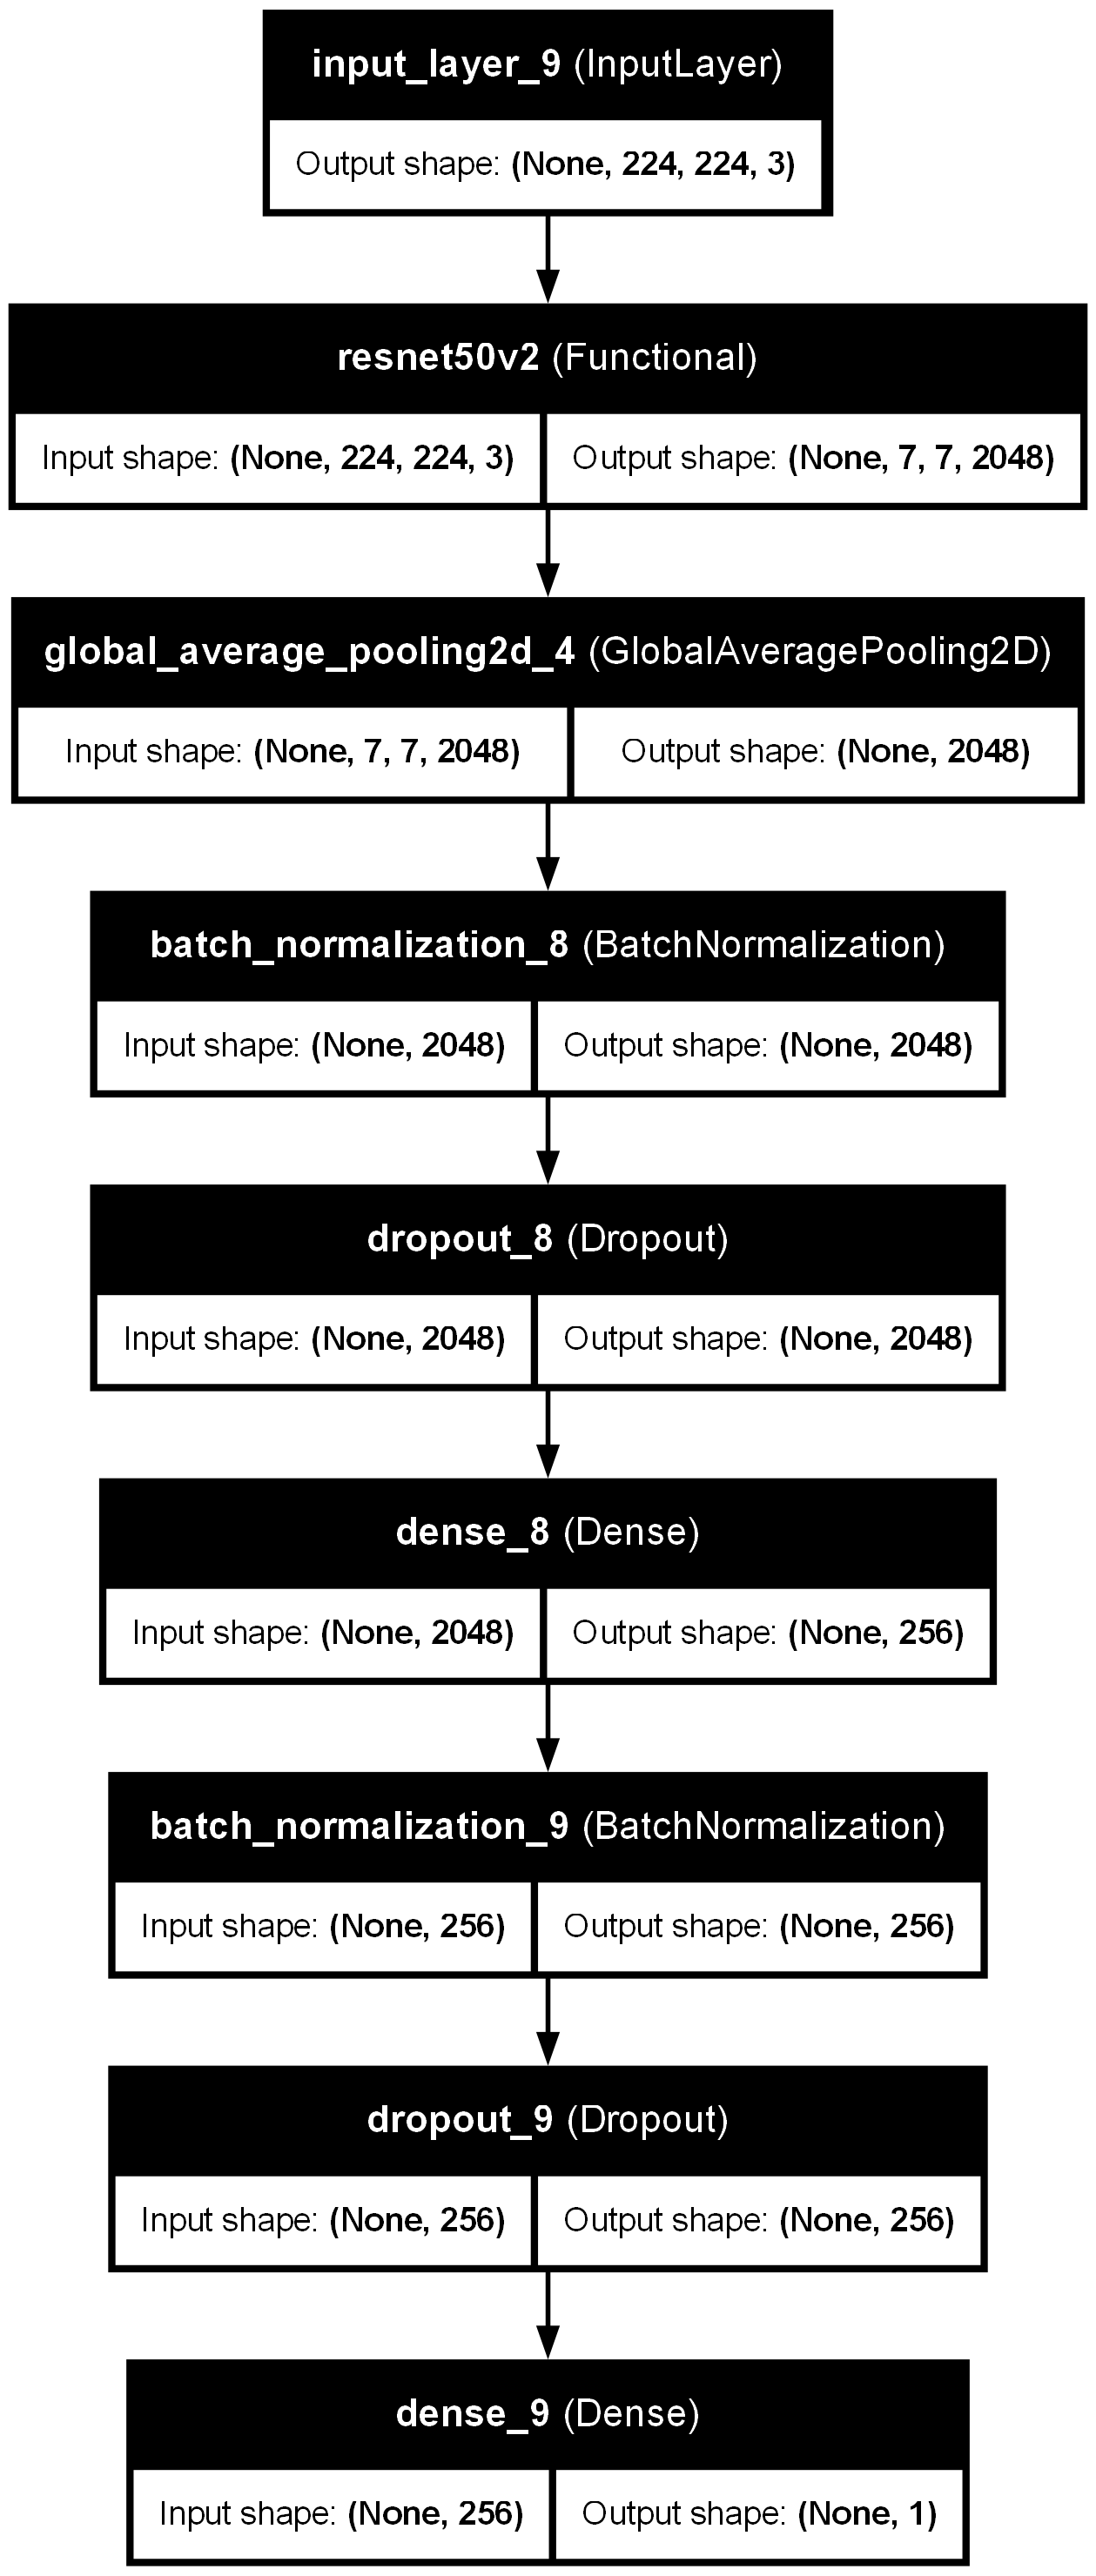

In [ ]:
# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False

callback = EarlyStopping(monitor='loss', patience=3)

# Create the model
inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


In [32]:
# # Define the pruning parameters
# pruning_params = {
#     'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.0,
#                                                  final_sparsity=0.5,
#                                                  begin_step=0,
#                                                  end_step=1000)
# }

# # Wrap the model in a Sequential to make it compatible with pruning
# pruned_model = tf.keras.Sequential([model])
# pruned_model = sparsity.prune_low_magnitude(pruned_model, **pruning_params)

In [27]:

steps_per_epoch = train_samples // batch_size
validation_steps = val_samples // batch_size

In [28]:

# Record the start time
start_time = time.time()

# Initial training
epochs = 50
history = model.fit(
    combined_train_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=combined_val_dataset,
    validation_steps=validation_steps,
    callbacks=[callback]
)


# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 77s 620ms/step - accuracy: 0.7372 - loss: 0.6637 - val_accuracy: 0.8675 - val_loss: 0.3414
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 73s 626ms/step - accuracy: 0.8683 - loss: 0.3214 - val_accuracy: 0.8775 - val_loss: 0.3093
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 74s 631ms/step - accuracy: 0.8912 - loss: 0.2796 - val_accuracy: 0.8712 - val_loss: 0.3402
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 74s 637ms/step - accuracy: 0.8946 - loss: 0.2325 - val_accuracy: 0.8813 - val_loss: 0.3199
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 74s 636ms/step - accuracy: 0.9134 - loss: 0.2066 - val_accuracy: 0.8763 - val_loss: 0.3588
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 75s 642ms/step - accuracy: 0.9181 - loss: 0.2063 - val_accuracy: 0.8750 - val_loss: 0.3232
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 75s 641ms/step - accuracy: 0.9327 - loss: 0.1710 - val_accuracy: 0.8788 - val_loss: 0.3117
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 75s 642ms/step - accuracy: 0.9252 - loss: 0

### Model Evaluation

In [30]:
print("Training data evaluation\n", model.evaluate(combined_train_dataset, steps=steps_per_epoch))
print("Validation data evaluation\n", model.evaluate(combined_val_dataset, steps=validation_steps))
print("Test data evaluation\n", model.evaluate(test_dataset, steps=validation_steps))

117/117 ━━━━━━━━━━━━━━━━━━━━ 113s 967ms/step - accuracy: 1.0000 - loss: 0.0092
Training data evaluation
 [0.009289945475757122, 1.0]
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 712ms/step - accuracy: 0.8546 - loss: 0.3946
Validation data evaluation
 [0.3575725257396698, 0.8662499785423279]
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 521ms/step - accuracy: 0.8729 - loss: 0.4558
Test data evaluation
 [0.3813978135585785, 0.887499988079071]


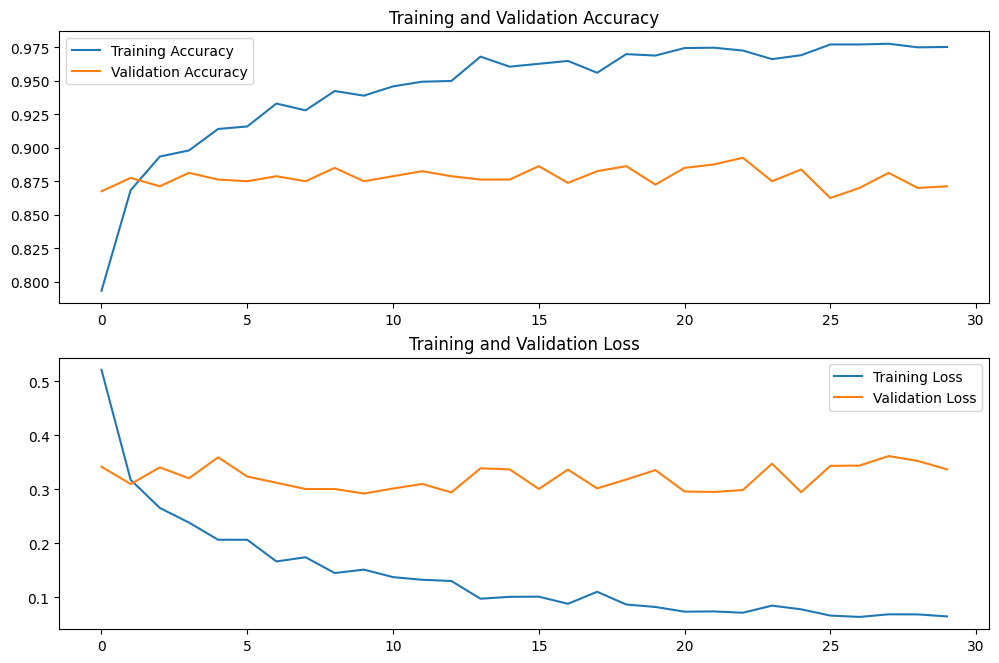

In [31]:
# Function to plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # precision = history.history.get('precision', [])
    # val_precision = history.history.get('val_precision', [])
    epochs = range(len(acc))

    plt.figure(figsize=(12, 12))
    
    # Plot accuracy
    plt.subplot(3, 1, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(3, 1, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    # # Plot precision
    # plt.subplot(3, 1, 3)
    # plt.plot(epochs, precision, label='Training Precision')
    # plt.plot(epochs, val_precision, label='Validation Precision')
    # plt.title('Training and Validation Precision')
    # plt.legend()
    # plt.show()

plot_history(history)

In [32]:
test_generator.reset()
while True:
    try:
        test_images, test_labels = next(test_generator)
        predictions = model.predict(test_images)

        fire_indices = np.where(test_labels == 1)[0]
        nofire_indices = np.where(test_labels == 0)[0]

        random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
        random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

        random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
        np.random.shuffle(random_indices)

        # Plot the images with predictions
        plt.figure(figsize=(20, 10))
        for i, idx in enumerate(random_indices):
            plt.subplot(2, 5, i+1)
            plt.imshow(test_images[idx])
            plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= 0.5 else 'Fire'}")
            plt.axis('off')

        plt.show()
        break
        
    except ValueError:
        pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390

KeyboardInterrupt: 

> **NOTE:** Due to alphabetical order "Fire" is labelled as "0" and "No Fire" is labelled as "1"

### 50% Threshold

d:\Dissertation\Kaggle Data\Wildfire 2\the_wildfire_dataset_2n_version\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 572ms/step


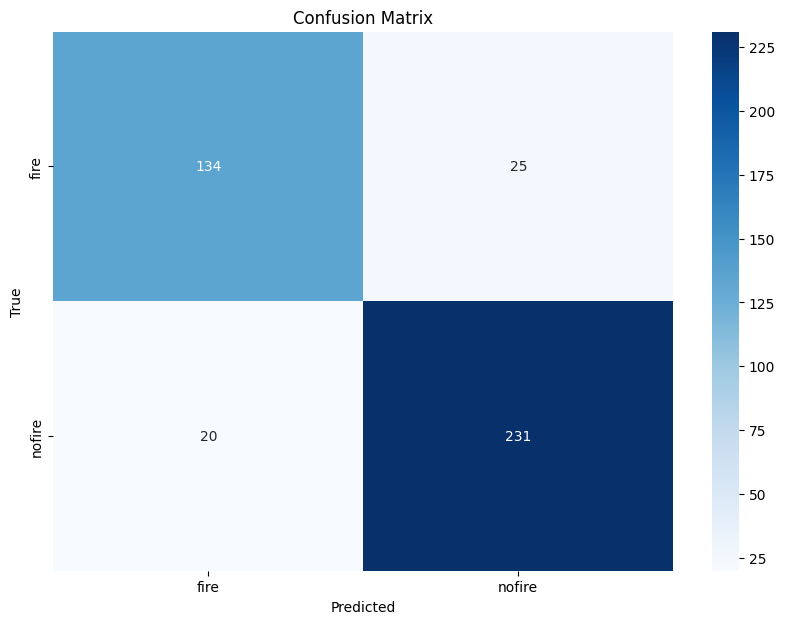

In [33]:

# Get the true labels and predicted labels
true_labels = test_generator.classes
predicted_labels = (model.predict(test_generator) >= 0.5).astype(int).flatten()

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Optimal Threshold

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 471ms/step


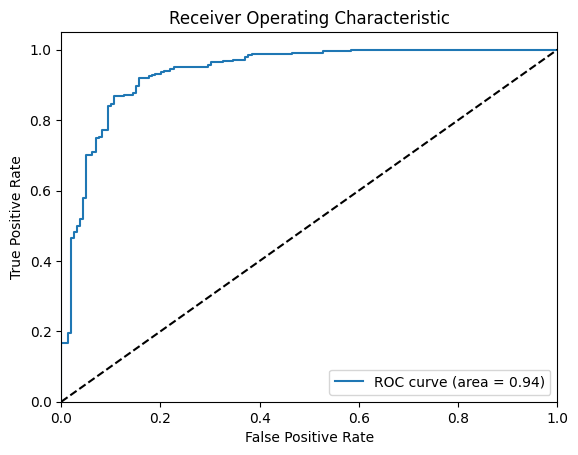

Optimal Threshold: 0.50351727


In [34]:
import numpy as np
from sklearn.metrics import roc_curve, auc


# Generate predictions on the validation set
# Generate predictions on the test set
y_pred_probs = model.predict(test_generator)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_generator.classes, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step


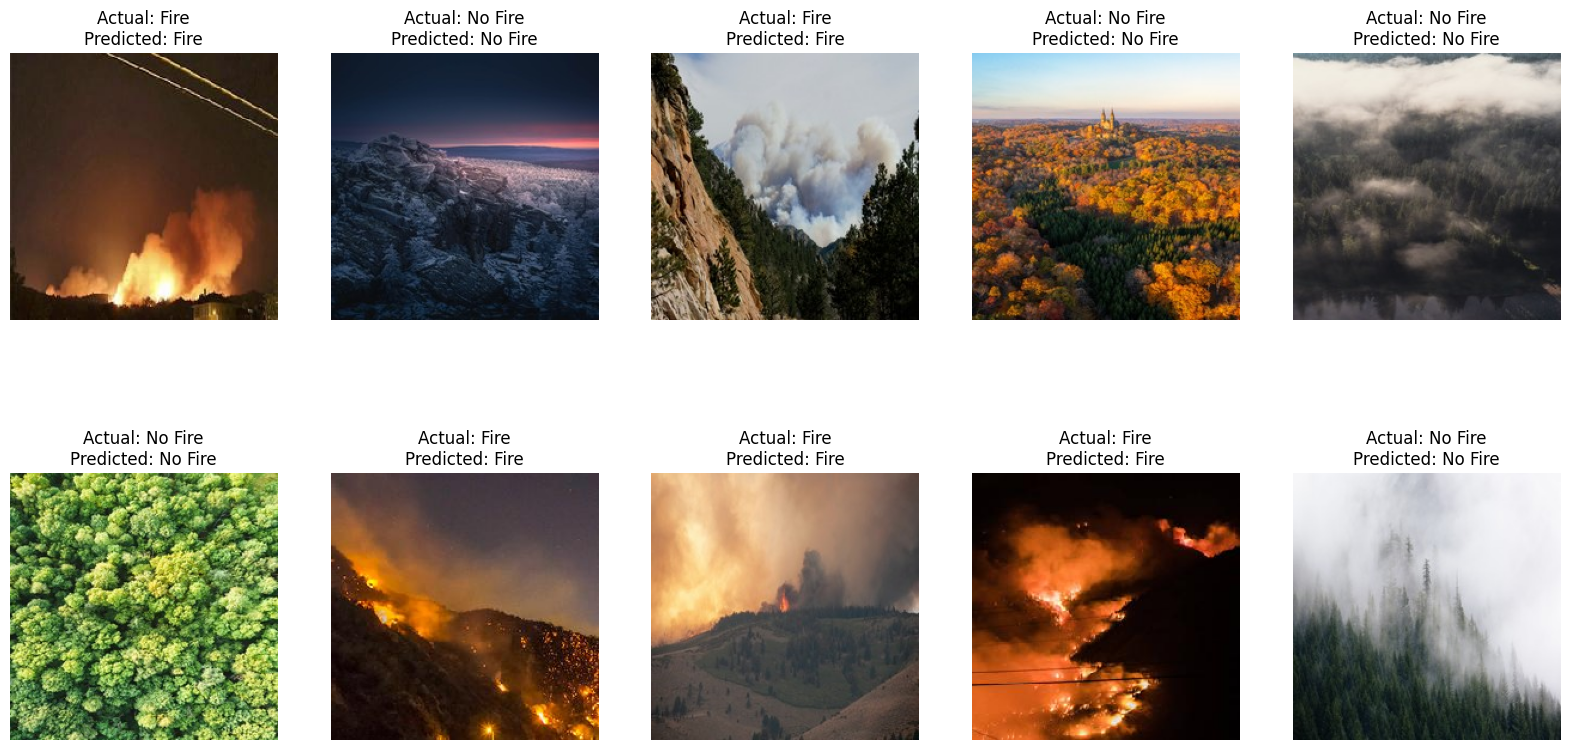

In [53]:
test_generator.reset()
while True:
    try:
        test_images, test_labels = next(test_generator)
        predictions = model.predict(test_images)

        fire_indices = np.where(test_labels == 1)[0]
        nofire_indices = np.where(test_labels == 0)[0]

        random_fire_indices = np.random.choice(fire_indices, 5, replace=False)
        random_nofire_indices = np.random.choice(nofire_indices, 5, replace=False)

        random_indices = np.concatenate((random_fire_indices, random_nofire_indices))
        np.random.shuffle(random_indices)

        # Plot the images with predictions
        plt.figure(figsize=(20, 10))
        for i, idx in enumerate(random_indices):
            plt.subplot(2, 5, i+1)
            plt.imshow(test_images[idx])
            plt.title(f"Actual: {'No Fire' if test_labels[idx] == 1 else 'Fire'}\nPredicted: {'No Fire' if predictions[idx] >= optimal_threshold else 'Fire'}")
            plt.axis('off')

        plt.show()
        break
        
    except ValueError:
        pass

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 496ms/step


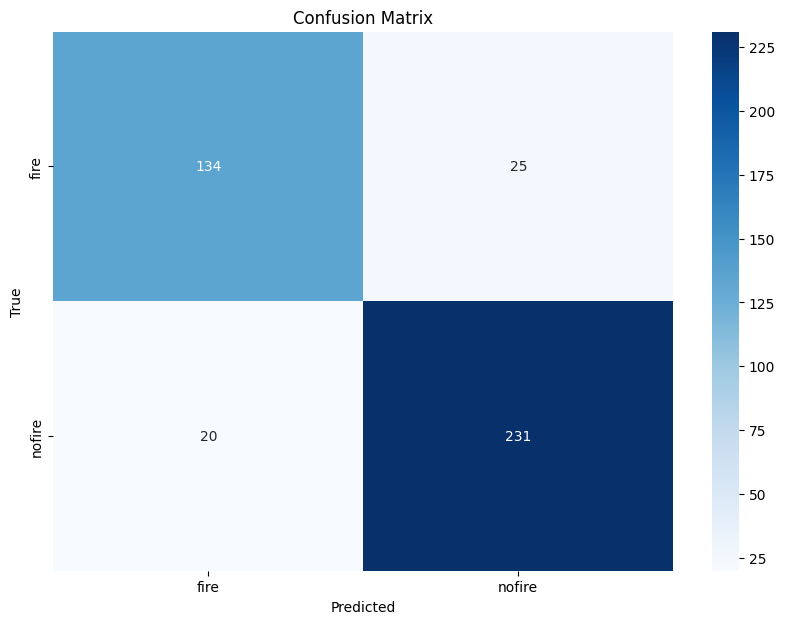

In [35]:

# Get the true labels and predicted labels
true_labels = test_generator.classes
predicted_labels = (model.predict(test_generator) >= optimal_threshold).astype(int).flatten()

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Save all files

In [ ]:
hist_df = pd.DataFrame(history.history) 
# Save the optimal threshold to a file
with open('optimal_threshold.txt', 'w') as f:
    f.write(str(optimal_threshold))

# Create directory structure
base_model_name = base_model.name
run_dirs = [d for d in os.listdir(base_model_name) if os.path.isdir(os.path.join(base_model_name, d)) and d.startswith('run_')]
run_number = len(run_dirs) + 1
run_dir = os.path.join(base_model_name, f'run_{run_number}')

os.makedirs(run_dir, exist_ok=True)

# Save the model, history, and optimal threshold in the new directory
model.save(os.path.join(run_dir, 'wildfire_detection_model.keras'))
hist_df.to_csv(os.path.join(run_dir, 'history.csv'), index=False)
with open(os.path.join(run_dir, 'optimal_threshold.txt'), 'w') as f:
    f.write(str(optimal_threshold))

# Save the confusion matrix plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(run_dir, 'confusion_matrix.png'))
plt.close()

# Save the training/validation accuracy and loss graphs
plot_history(history)
plt.savefig(os.path.join(run_dir, 'training_validation_accuracy_loss.png'))
plt.close()

# Save the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(os.path.join(run_dir, 'roc_curve.png'))
plt.close()

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Save the training time to a file
with open(os.path.join(run_dir, 'training_time.txt'), 'w') as f:
    f.write(f"{training_time:.6f}")